# Exercise
## You are given, as the train data, trn_x and trn_y along with their class labels trn_x_class and trn_y_class. The task is to classify the following TEST data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal as norm

First we load the data from the text files

In [2]:
# Train data
train_x = np.loadtxt("data/trn_x.txt")
train_x_label = np.loadtxt("data/trn_x_class.txt")

train_y = np.loadtxt("data/trn_y.txt")
train_y_label = np.loadtxt("data/trn_y_class.txt")

# Test data
test_x = np.loadtxt("data/tst_x.txt")
test_x_label = np.loadtxt("data/tst_x_class.txt")

test_y = np.loadtxt("data/tst_y.txt")
test_y_label = np.loadtxt("data/tst_y_class.txt")

test_y_126 = np.loadtxt("data/tst_y_126.txt")
test_y_126_label = np.loadtxt("data/tst_y_126_class.txt")

test_xy = np.loadtxt("data/tst_xy.txt")
test_xy_label = np.loadtxt("data/tst_xy_class.txt")

test_xy_126 = np.loadtxt("data/tst_xy_126.txt")
test_xy_126_label = np.loadtxt("data/tst_xy_126_class.txt")


Looking at the data we see that our input features is 2-dimensional, i.e., it has two values per data point.
Furthermore, x has label 1 and y has label 2.

Let's visualize the training data by plotting a 2D scatter plot and corresponding Gaussians for class x and class y

In [3]:
# Hint: look at: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html 

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



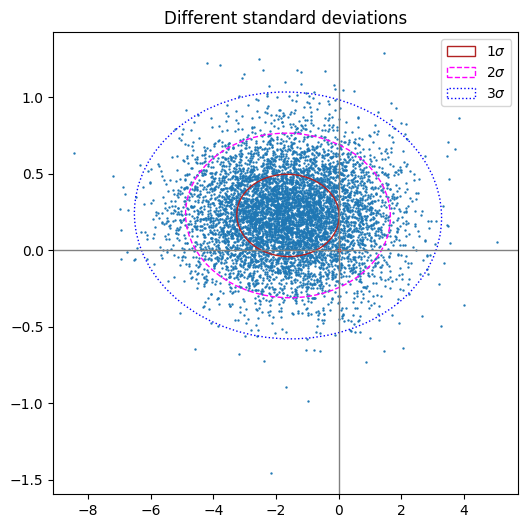

In [4]:
np.random.seed(0)

fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = train_x[:,0], train_x[:,1]
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

### (a) classify instances in tst_xy, and use the corresponding label file tst_xy_class to calculate the accuracy;

First we compute the statistics of x and y (use np.mean and np.cov)

In [5]:
# x statistics
train_x_mean = np.mean(train_x, axis=0)
train_x_cov = np.cov(train_x.T)

# y statistics
train_y_mean = np.mean(train_y, axis=0)
train_y_cov =  np.cov(train_y.T)

# priors
# the prior probabilities of each class is simply the probability of the given class occuring in the complete dataset
prior_x = len(train_x) / (len(train_x) + len(train_y))
prior_y = 1-prior_x

print("Prior x: ", prior_x)
print("Prior y: ", prior_y)

Prior x:  0.5543040368330182
Prior y:  0.4456959631669818


Now we need to a function for computing the likelihood of x and y given our test data.

In [6]:
# Define likelihood function
# Implement your own or look on stack overflow if you are lazy - most important thing is that you understand what is going on

def likelihood(data, mean, cov):
    likelihood_value = norm(mean=mean, cov=cov).pdf(data)
    return likelihood_value

To classify the test data we compute the likelihood of it being class x and class y

In [7]:
# Compute likelihood of x and y
likelihood_x = likelihood(test_xy, train_x_mean, train_x_cov)
likelihood_y = likelihood(test_xy, train_y_mean, train_y_cov)

We compute the posterior probability by taking the priors into account

For some reason we can just remove the evidence term, as it is just normalization which is not needed for classification
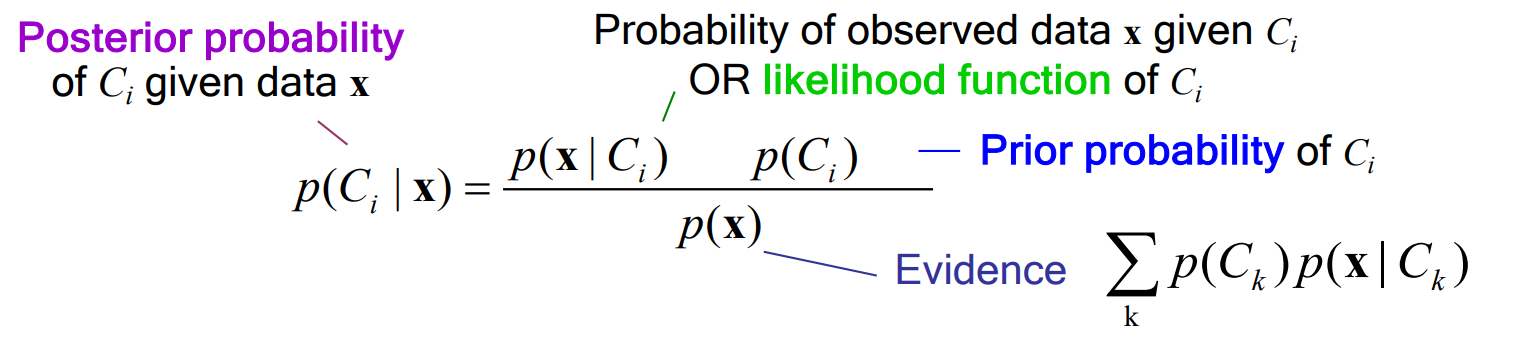


In [8]:
# Compute posteriors from likelihood and prior
posterior_x = likelihood_x * prior_x
posterior_y = likelihood_y * prior_y

Now choose to classify our test data as belonging to the class with the highest posterior probability

In [9]:
# Remember that labels for x and y are are 1 and 2 respectively
# argmax returns the index of the maximum value
stacked = np.stack([posterior_x, posterior_y])
classification = np.argmax(stacked, axis=0) + 1


We can compute the accuracy of our classifications by taking the sum of correct predictions and divide by the total number of predictions

In [10]:
accuracy_xy = np.sum(classification == test_xy_label) / len(test_xy_label)
print("Accuracy XY: ", accuracy_xy)

Accuracy XY:  0.9097187962506167


### (b) classify instances in tst_xy_126 by assuming a uniform prior over the space of hypotheses, and use the corresponding label file tst_xy_126_class to calculate the accuracy;

First we define our prior probabilities

In [11]:
# prior_x_uniform = ?
# prior_y_uniform = ?


We can now compute posteriors knowing that the posterior probability is simply the prior, p(C), multiplied by the likelihood p(x, C).

In [12]:
# likelihood_x_uniform = ?
# likelihood_y_uniform = ?

# posterior_x_uniform = ?
# posterior_y_uniform = ?

Now that we have posteriors for both x and y we can classify the test data and compute the accuracy

In [13]:
# classification_uniform = ?

# accuracy_xy_126_uniform = ?
# print(f"Accuracy using uniform prior {accuracy_xy_126_uniform*100:.2f}%")

### (c) classify instances in tst_xy_126 by assuming a prior probability of 0.9 for Class x and 0.1 for Class y, and use the corresponding label file tst_xy_126_class to calculate the accuracy; compare the results with those of (b).

Here we simply follow the procedure of (b), however, this time with updated priors

In [14]:
# prior_x_non_uniform = ?
# prior_y_non_uniform = ?

# likelihood_x_non_uniform = ?
# likelihood_y_non_uniform = ?
# posterior_x_non_uniform = ?
# posterior_y_non_uniform = ?

# classification_non_uniform = ? 

# accuracy_xy_126_non_uniform = ?

# print(f"Accuracy using non-uniform prior {accuracy_xy_126_non_uniform*100:.2f}%")

Comparing the accuracy using uniform prior and non-uniform priors we see that using prior information about the data distribution improves classifcation accuracy by ?%.

In [15]:
# improvement = (accuracy_xy_126_non_uniform / accuracy_xy_126_uniform) - 1
# print(f"Absolute improvement in accuracy {improvement*100:.2f}%")